In [1]:
##load modules
import pandas as pd
import numpy as np

In [2]:
#load data
##load excel sheet that states relationship between change of indicator and progress
relationship = pd.read_excel('MPR3 SDG Indicators_03.xlsx', sheet_name="Indicator List")
relationship = pd.DataFrame(relationship, columns=['Indicator Number', 'SDG Environment Indicators', 'Relationship to Progress', 'IndicatorID', 'SeriesDescription'])
###rename column 'indicator number' & Indicator name column
relationship = relationship.rename(columns={'Indicator Number': 'Indicator', 'SDG Environment Indicators': 'Indicator Name'})

##load MPR3 data; only load columns GeoAreaCode, GeoAreaName, TimePeriod, Value
MPR3 = pd.read_excel('92 SDG Indicators data 061022.xlsx', usecols="A,B,G:J")
MPR3 = MPR3.rename(columns={"Indicator_ID": "IndicatorID"})

In [3]:
#merge data
##merge relationship with MPR3 data on IndicatorID
###skip Indicator column of MPR3, because it's misleading
data = pd.merge(left=MPR3.loc[:, MPR3.columns!='Indicator'], right=relationship[["Indicator", 'Relationship to Progress', "IndicatorID","Indicator Name", "SeriesDescription"]], how='right', on='IndicatorID')

In [4]:
#limit df to relevant regions:
## 1 - World
## 202 - Sub-Saharan Africa (M49), []
## 62 - Central Asia (M49) and Southern Asia (MDG=M49),
## 753 - Eastern Asia (M49) and South-eastern Asia (MDG=M49)
## 9 - Oceania (M49)
## 150 - Europe (M49)
## 21 - Northern America (M49)
## 419 - Latin America and the Caribbean (MDG=M49)
## 145 - Western Asia (M49)
## 15 - Northern Africa (M49)

data = data[data.GeoAreaCode.isin([1, 202, 62, 753, 9, 150, 21, 419, 145, 15])]

In [5]:
regions_dict = {
    1: 'World',
    202: 'Sub-Saharan Africa',
    62: 'Central and Southern Asia',
    753: 'Eastern and South-eastern Asia',
    9: 'Oceania',
    150: 'Europe',
    21: 'Northern America',
    419: 'Latin America and the Caribbean',
    145: 'Western Asia',
    15: 'Northern Africa'
}

test_dict = {
    1: 'World',
    202: 'Sub-Saharan Africa'
}

In [6]:
def mpr_excel_data(GeoAreaCode):
    #PREPARE DATA
    df = data[data['GeoAreaCode'] == GeoAreaCode]
    #find missing indicators
    missing_indicators = [i for i in relationship.Indicator.unique() if i not in df.Indicator.unique()]
    #add missing indicators to dataset
    ##create df that includes missing indicators
    adding_df = pd.DataFrame({
            "Indicator": missing_indicators,
            "GeoAreaCode": 202,
            'GeoAreaName': np.nan,
            'TimePeriod': 2000,
            'Value': np.nan})

    #Add indicator ID to newly added indicators
    adding_df_new = pd.merge(left=adding_df, right=relationship[["Indicator", 'Relationship to Progress', "IndicatorID","Indicator Name", "SeriesDescription"]], how='left', on='Indicator')
    #get columns in right order
    adding_df_new = adding_df_new[['IndicatorID', 'Indicator', 'GeoAreaCode', 'GeoAreaName', 'TimePeriod', 'Value', 'Relationship to Progress', 'Indicator Name', 'SeriesDescription']]

    ##add adding_df to df
    df = df.append(adding_df_new)
    #limit df to relevant indicators
    df = df[df.Indicator.isin(relationship.Indicator.unique())]

    #CREATE PIVOT TABLE
    df_pivot = pd.pivot_table(data = df, index = 'Indicator', columns='TimePeriod', values="Value", aggfunc=np.sum)
    #add column indicating newest data point of each row (= last value in row)
    df_pivot['Newest Data'] = df_pivot.fillna(method='ffill', axis=1).iloc[:, -1]
    #add column indicating oldest data point of each row (= first value in row)
    df_pivot['Oldest Data'] = df_pivot.fillna(method='bfill', axis=1).iloc[:, 0]

    #calculate percentage of change over full monitoring period via (newest data - oldest data)/ oldest data * 100
    df_pivot['Change'] = (df_pivot['Newest Data'] - df_pivot['Oldest Data']) / df_pivot['Oldest Data'] * 100

    #sort pivot table on indicator
    ##rest index => free indicator column
    df_pivot = df_pivot.reset_index()
    ##convert indicator column into type category
    df_pivot.Indicator = df_pivot.Indicator.astype('category')
    ##set categories according to correct indicator list
    df_pivot.Indicator.cat.set_categories(relationship['Indicator'].unique(), inplace=True)
    ##sort pivot on indicator
    df_pivot.sort_values(['Indicator'], inplace=True)

    ##reverse to dtype string
    ###needed for inserting values at MPR3 values
    df_pivot.Indicator = df_pivot.Indicator.astype('string')

    ##make indicator index again
    df_pivot.set_index(['Indicator'], inplace=True)

    #add relationship column to pivot table
    ##add as new column
    df_pivot['Relationship'] = list(relationship['Relationship to Progress'])
    ##add Sub-indicator & description as new columns
    df_pivot["Sub-Indicator"] = list(relationship["IndicatorID"])
    df_pivot["SeriesDescription"] = list(relationship["SeriesDescription"])

    #ADD MPR Status
    #write function to assess status
    def status_handler(row):
        if (row['Change'] >= 1) & (row['Relationship'] =='direct'):
            return 'Positive change'
        if (row['Change'] <= -1) & (row['Relationship'] =='direct'):
            return 'Negative change'
        if (row['Change'] >= 1) & (row['Relationship'] =='indirect'):
            return 'Negative change'
        if (row['Change'] <= -1) & (row['Relationship'] =='indirect'):
            return 'Positive change'
        if (row['Change'] == 0) & (row[:23].count() == 1):
            return "Some data"
        if (row['Change'] == 0) :
            return 'Little change'
        if (row['Change'] >= -1) & (row['Change'] <= 1):
            return 'Little change'
        if (np.isnan(row['Change'])):
            return 'No data'
    
    #Add Status column
    df_pivot['MPR3 Status'] = df_pivot.apply(status_handler, axis=1)
    #Turn 0.000 from 2000 into NA values if count MP3 Status is No Data (means that rows was added artificially)
    ##NB: data is falsely represented by zero because of sum function of pivot table
    df_pivot[2000] = np.where((df_pivot[2000] == 0) & (df_pivot["MPR3 Status"] == 'No data'), np.nan, df_pivot[2000])

    #RETURN DF_PIVOT
    return (df_pivot)

In [7]:
#run function for all regions and resulting df to dictionary
sheets={}
for GeoAreaCode, region in regions_dict.items():
    #run function
    df = mpr_excel_data(GeoAreaCode)
    #save in dict
    sheets[str(region)]=df

C:\Users\KS\AppData\Local\Temp\ipykernel_6316\3864488902.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(adding_df_new)
C:\Users\KS\anaconda3\lib\site-packages\pandas\core\arrays\categorical.py:2747: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
C:\Users\KS\AppData\Local\Temp\ipykernel_6316\3864488902.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(adding_df_new)
C:\Users\KS\anaconda3\lib\site-packages\pandas\core\arrays\categorical.py:2747: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused 

In [8]:
sheets.keys()

dict_keys(['World', 'Sub-Saharan Africa', 'Central and Southern Asia', 'Eastern and South-eastern Asia', 'Oceania', 'Europe', 'Northern America', 'Latin America and the Caribbean', 'Western Asia', 'Northern Africa'])

In [9]:
#export df to excel
writer = pd.ExcelWriter(path= r'C:\Users\KS\OneDrive - United Nations\Karl Scheifinger 2022\Task1_MP3- Scorecards\Output.xlsx', engine='xlsxwriter')
for sheet in sheets:
    sheets[sheet].to_excel(writer, sheet_name=str(sheet), index=True, header=True)
writer.save()

In [ ]:
#PLAYING AROUND WITH VISUALISATION
import matplotlib.pyplot as plt


In [ ]:
dat = pd.DataFrame()
for key, dataframe in sheets.items():
    dataframe['Area'] = [key]*109
    dat = pd.concat([dat,dataframe])

dat.reset_index(inplace=True)
dat = dat[['Indicator', 'MPR3 Status', "Area"]]
#rename MPR3
dat = dat.rename(columns={'MPR3 Status' : 'Status'})

#add column that translates Status into number
def translator (row):
    if (row['Status'] == "No data"):
        return 1
    if (row['Status'] == "Some data"):
        return 2
    if (row['Status'] == "Negative change"):
        return 3
    if (row['Status'] == "Little change"):
        return 4
    if (row['Status'] == "Positive change"):
        return 5

def colour_bar (row):
    if (row['Status'] == "No data"):
        return "grey"
    if (row['Status'] == "Some data"):
        return "silver"
    if (row['Status'] == "Negative change"):
        return "coral"
    if (row['Status'] == "Little change"):
        return "gold"
    if (row['Status'] == "Positive change"):
        return "cornflowerblue"

dat['Value'] = dat.apply(translator, axis=1)
dat["Color"] = dat.apply(colour_bar, axis=1)

dat.Status = dat.Status.astype('category')
##set categories according to correct indicator list
dat.Status.cat.set_categories(["No data", "Some data", "Negative change", "Little change", "Positive change"], inplace=True)

In [ ]:
#dat.set_index("Indicator", inplace=True)

KeyError: "None of ['Indicator'] are in the columns"

In [ ]:
relevant = dat.Indicator.str.startswith("1.")
to_plot=dat[relevant]


In [ ]:
#to_plot.set_index('Indicator', inplace=True)
to_plot_pivot = pd.pivot_table(
    to_plot,
    values="Value",
    index="Indicator",
    columns="Area",
    aggfunc=np.mean
)

to_plot_pivot.reset_index(inplace=True)
to_plot_pivot.Indicator = to_plot_pivot.Indicator.astype('category')
##set categories according to correct indicator list
to_plot_pivot.Indicator.cat.set_categories(relationship['Indicator'].unique(), inplace=True)
to_plot_pivot.set_index("Indicator", inplace=True)

In [ ]:
to_plot_pivot

Area,Central and Southern Asia,Eastern and South-eastern Asia,Europe,Latin America and the Caribbean,Northern Africa,Northern America,Oceania,Sub-Saharan Africa,Western Asia,World
Indicator,,,,,,,,,,
1.4.2,1,1,1,1,1,1,1,1,1,1
1.5.1,1,1,1,1,1,1,1,1,1,1
1.5.2,5,1,3,5,3,3,5,3,2,5
1.5.3,1,1,1,1,1,1,1,1,1,1
1.5.4,1,1,1,1,1,1,1,1,1,1


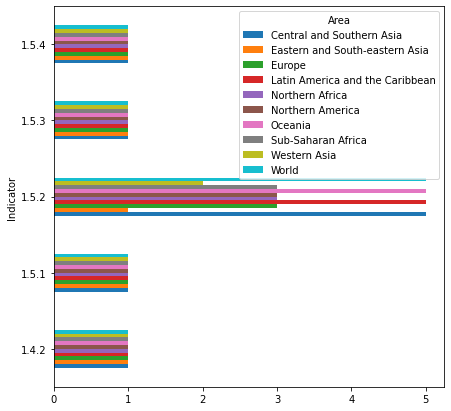

In [ ]:
ax = to_plot_pivot.plot(kind="barh")

fig = ax.get_figure()
fig.set_size_inches(7,7)

In [ ]:
df

TimePeriod,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2018,2019,2020,2021,2022,Newest Data,Oldest Data,Change,Relationship,MPR3 Status
Indicator,,,,,,,,,,,,,,,,,,,,,
1.4.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,NaN,direct,No data
1.5.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,NaN,indirect,No data
1.5.2,NaN,NaN,NaN,NaN,NaN,8319.46007,8321.03277,8180.97561,8195.64115,8574.20259,...,9.155412e+08,1.190231e+07,NaN,NaN,NaN,1.190231e+07,8.319460e+03,142965.878513,indirect,Negative change
1.5.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,NaN,direct,No data
1.5.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,NaN,direct,No data
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17.7.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.399296e+10,1.198029e+10,7.898004e+09,NaN,NaN,7.898004e+09,1.767666e+10,-55.319589,direct,Negative change
17.9.1,1229.81027,1377.2614,940.80176,921.51972,1192.46866,1153.09409,1218.23708,1592.39769,1548.36939,2070.53909,...,2.614864e+03,2.202218e+03,1.913931e+03,NaN,NaN,1.913931e+03,1.229810e+03,55.628162,direct,Positive change
17.14.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,NaN,direct,No data
